In [1]:
import os
import sys
import pandas as pd, geopandas as gp, matplotlib.pyplot as plt, numpy as np
import json
import fiona
import sys
import getpass
import requests
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
import contextily as ctx

user = getpass.getuser()
sys.dont_write_bytecode = True

sys.path.insert(0, '/Users/{}/Box/DataViz Projects/Utility Code'.format(user))

from utils_io import *

In [2]:
data_dir = '../../../Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/data/'

# RHNA Site Selection Pre-Screening Dataset Processing

## Approach

Develop a parcel-level dataset containing factors required by HCD as well as optional factors such as whether the site is located within a high opportunity area, or a transportation priority area, any floor area ratio requirements of the site, etc. The dataset will be developed from a combination of publically available datasets as well as datasets developed by MTC/ABAG from local governments and counties throughout the Bay Area.

## Data Sources

**[Data Sources Inventory](https://mtcdrive.app.box.com/file/700718735166)**

## Step1: Create housing sites dataset on socrata

- This step creates an empty table on the Socrata platform which will serve as our database for following steps

In [8]:
dataset_name= 'Housing Element Site Selection Parcels v3'
dataset_desc= 'This dataset contains regional parcels from 2018 with factors used to support development of a site selection pre-screening tool'
columns = [{'fieldName': 'parcel_id', 'name': 'parcel_id' , 'dataTypeName': 'text'},
           {'fieldName': 'geom_id', 'name': 'geom_id' , 'dataTypeName': 'text'},
           {'fieldName': 'county', 'name': 'county' , 'dataTypeName': 'number'},
           {'fieldName': 'city', 'name': 'city' , 'dataTypeName': 'text'},
           {'fieldName': 'apn', 'name': 'apn' , 'dataTypeName': 'text'},
           {'fieldName': 'apn_raw', 'name': 'apn_raw' , 'dataTypeName': 'text'},
           {'fieldName': 'centroid_x', 'name': 'centroid_x' , 'dataTypeName': 'number'},
           {'fieldName': 'centroid_y', 'name': 'centroid_y' , 'dataTypeName': 'number'},
          {'fieldName': 'acres', 'name': 'acres' , 'dataTypeName': 'number'},
           {'fieldName': 'parcel_type', 'name': 'parcel_type' , 'dataTypeName': 'text'},
           {'fieldName': 'joinid_geoserver', 'name': 'joinid_geoserver' , 'dataTypeName': 'text'},
           {'fieldName': 'exist_lu', 'name': 'existing_land_use' , 'dataTypeName': 'text'},
           {'fieldName': 'public_own', 'name': 'public_ownership' , 'dataTypeName': 'number'},
           {'fieldName': 'vacant', 'name': 'vacant' , 'dataTypeName': 'number'},
           {'fieldName': 'underutilized', 'name': 'underutilized' , 'dataTypeName': 'number'},
           {'fieldName': 'zn_code', 'name': 'zoning_code' , 'dataTypeName': 'text'},
           {'fieldName': 'zn_description', 'name': 'zoning_description' , 'dataTypeName': 'text'},
           {'fieldName': 'zn_area_overlay', 'name': 'zoning__area_overlay' , 'dataTypeName': 'text'},
           {'fieldName': 'zn_max_dua', 'name': 'zoning_max_dua' , 'dataTypeName': 'number'},
           {'fieldName': 'gp_code', 'name': 'general_plan_code' , 'dataTypeName': 'text'},
           {'fieldName': 'gp_description', 'name': 'general_plan_description' , 'dataTypeName': 'text'},
           {'fieldName': 'gp_max_dua', 'name': 'general_plan_max_dua' , 'dataTypeName': 'number'},
           {'fieldName': 'fmr_0bdr', 'name': 'fmr_0bdr' , 'dataTypeName': 'number'},
           {'fieldName': 'fmr_1bdr', 'name': 'fmr_1bdr' , 'dataTypeName': 'number'},
           {'fieldName': 'fmr_2bdr', 'name': 'fmr_2bdr' , 'dataTypeName': 'number'},
           {'fieldName': 'fmr_3bdr', 'name': 'fmr_3bdr' , 'dataTypeName': 'number'},
           {'fieldName': 'fmr_4bdr', 'name': 'fmr_4bdr' , 'dataTypeName': 'number'},
           {'fieldName': 'fmr_4plbdr', 'name': 'fmr_4plbdr' , 'dataTypeName': 'number'},
          {'fieldName': 'tract_geoi', 'name': 'tract_geoid' , 'dataTypeName': 'text'},
           {'fieldName': 'blkgp_geoi', 'name': 'block_group_geoid' , 'dataTypeName': 'text'},
           {'fieldName': 'reso_level', 'name': 'hcd_community_resource_level' , 'dataTypeName': 'text'},
           {'fieldName': 'fire_risk', 'name': 'calfire_fire_risk' , 'dataTypeName': 'text'},
           {'fieldName': 'fire_autho', 'name': 'calfire_regulatory_authority' , 'dataTypeName': 'text'},
           {'fieldName': 'sea_level', 'name': 'bcdc_sea_level_rise' , 'dataTypeName': 'number'},
           {'fieldName': 'cpad', 'name': 'cal_protected_area_database' , 'dataTypeName': 'number'},
           {'fieldName': 'urban_serv', 'name': 'urban_service_area' , 'dataTypeName': 'number'},
           {'fieldName': 'tra', 'name': 'transit_rich_area' , 'dataTypeName': 'number'},
           {'fieldName': 'pda', 'name': 'priority_development_area' , 'dataTypeName': 'number'},
           {'fieldName': 'rhna_5', 'name': 'rhna_5' , 'dataTypeName': 'number'},
           {'fieldName': 'rhna_4', 'name': 'rhna_4' , 'dataTypeName': 'number'},
           {'fieldName': 'bldg_permi', 'name': 'bldg_permi' , 'dataTypeName': 'number'},
           {'fieldName': 'vmt', 'name': 'vehicle_miles_traveled' , 'dataTypeName': 'number'},
           {'fieldName': 'x_centroid', 'name': 'x_centroid' , 'dataTypeName': 'number'},
           {'fieldName': 'y_centroid', 'name': 'y_centroid' , 'dataTypeName': 'number'},
          {'fieldName': 'shape', 'name': 'shape' , 'dataTypeName': 'multipolygon'}]
category= 'Land & People'
tags = ['housing','housing element','site selection','hcd','housing and community development','rhna']
row_identifier='parcel_id'
create_socrata_dataset(dataset_name,dataset_desc,columns,category,tags,row_identifier)

created dataset on Socrata with id: d8wd-vg4y


{'id': 'd8wd-vg4y',
 'name': 'Housing Element Site Selection Parcels v3',
 'averageRating': 0,
 'category': 'Land & People',
 'createdAt': 1597867900,
 'description': 'This dataset contains regional parcels from 2018 with factors used to support development of a site selection pre-screening tool',
 'displayType': 'table',
 'downloadCount': 0,
 'hideFromCatalog': False,
 'hideFromDataJson': False,
 'newBackend': True,
 'numberOfComments': 0,
 'oid': 34997724,
 'provenance': 'official',
 'publicationAppendEnabled': False,
 'publicationGroup': 17463000,
 'publicationStage': 'unpublished',
 'rowIdentifierColumnId': 489282357,
 'rowsUpdatedAt': 1597867900,
 'tableId': 17463000,
 'totalTimesRated': 0,
 'viewCount': 0,
 'viewLastModified': 1597867903,
 'viewType': 'tabular',
 'columns': [{'id': 489282357,
   'name': 'parcel_id',
   'dataTypeName': 'text',
   'fieldName': 'parcel_id',
   'position': 1,
   'renderTypeName': 'text',
   'tableColumnId': 112563448,
   'format': {}},
  {'id': 48928

In [9]:
#Socrata housing site selection db 4x4
housing_site_db_id = 'd8wd-vg4y'

## Step 2: Pull regional parcel data from Socrata as geojson

- This step pulls in parcel data collected from each County Assessor's office in the 9-County Bay Area in 2018
- These data were processed, cleaned, and standardized by the Data & Visualization team 
- These data will serve the 'framework' data, which overlay data attributes will be added to 

In [5]:
parcel_geojson = pull_geojson_from_socrata('qqfm-y9ey')

pulling 2142677 rows as geojson


In [10]:
parcel_geojson['features']

[{'type': 'Feature',
  'geometry': {'type': 'MultiPolygon',
   'coordinates': [[[[-121.9314340609999, 37.51750546500006],
      [-121.931430807, 37.51747140700007],
      [-121.9317934489999, 37.51756071000005],
      [-121.931792618, 37.51756284000004],
      [-121.931791854, 37.51756492300007],
      [-121.931791136, 37.51756701700003],
      [-121.9317904659999, 37.51756911800004],
      [-121.9317898369999, 37.51757123000004],
      [-121.931789264, 37.51757334900003],
      [-121.931788732, 37.51757547500006],
      [-121.9317882459999, 37.51757761100004],
      [-121.931787808, 37.51757975300006],
      [-121.9317874179999, 37.51758189700007],
      [-121.93178707, 37.51758405200007],
      [-121.931786776, 37.51758620700008],
      [-121.931786528, 37.51758836600004],
      [-121.931786325, 37.51759053000006],
      [-121.93178617, 37.51759269600007],
      [-121.931786064, 37.51759486200007],
      [-121.931786005, 37.51759703300007],
      [-121.931785991, 37.51759919700004],


In [12]:
# Convert to geojson to geodataframe
parcels = gp.GeoDataFrame.from_features(parcel_geojson['features'],
                                        crs='EPSG:4326')

In [13]:
parcels.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
parcels.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2142677 entries, 0 to 2142676
Data columns (total 12 columns):
 #   Column            Dtype   
---  ------            -----   
 0   geometry          geometry
 1   parcel_type       object  
 2   city              object  
 3   acres             object  
 4   geom_id           object  
 5   apn_raw           object  
 6   centroid_y        object  
 7   county            object  
 8   centroid_x        object  
 9   parcel_id         object  
 10  apn               object  
 11  joinid_geoserver  object  
dtypes: geometry(1), object(11)
memory usage: 196.2+ MB


### Upsert to socrata

In [17]:
#Convert geom type from polygon to multipolygon before upsert
parcels['geometry']= [MultiPolygon([feature]) if type(feature) == Polygon \
    else feature for feature in parcels["geometry"]]

In [18]:
#Convert geometry to wkt format before upserting to socrata
parcels['shape'] = parcels['geometry'].map(lambda x: x.wkt)

In [20]:
parcels.head(5)

,geometry,parcel_type,city,acres,geom_id,apn_raw,centroid_y,county,centroid_x,parcel_id,apn,joinid_geoserver,shape
0,"MULTIPOLYGON (((-121.93143 37.51751, -121.9314...",PT00,Fremont,0.130282673690588,N519787380022023374,513-733-63,37.517590870352,1.0,-121.931593621497,AL513073306300,513073306300,AL050297,MULTIPOLYGON (((-121.9314340609999 37.51750546...
1,"MULTIPOLYGON (((-121.87482 37.70703, -121.8748...",PT00,Dublin,0.134538967957149,7777965113668899400,986-21-92,37.7069546035818,1.0,-121.874998288998,AL986002109200,986002109200,AL064565,MULTIPOLYGON (((-121.874822287 37.707028194000...
2,"MULTIPOLYGON (((-122.18964 37.79015, -122.1897...",PT00,Oakland,0.0596464335915547,8592358637913523614,30-1939-18,37.7901961828431,1.0,-122.189772409697,AL030193901800,030193901800,AL027583,MULTIPOLYGON (((-122.189637685 37.790153423000...
3,"MULTIPOLYGON (((-122.29172 37.88002, -122.2919...",PT00,Berkeley,0.0652835256088313,N3603110186859102487,60-2400-17,37.8800674363449,1.0,-122.291838389711,AL060240001700,060240001700,AL132639,MULTIPOLYGON (((-122.291720683 37.880021532000...
4,"MULTIPOLYGON (((-121.86951 37.73175, -121.8694...",PT00,Dublin,0.157939883697465,N7048726851848113656,985-56-4,37.731050067,1.0,-121.870061053204,AL985005600400,985005600400,AL065372,MULTIPOLYGON (((-121.869508097 37.731754854000...


In [21]:
parcels.columns

Index(['geometry', 'parcel_type', 'city', 'acres', 'geom_id', 'apn_raw',
       'centroid_y', 'county', 'centroid_x', 'parcel_id', 'apn',
       'joinid_geoserver', 'shape'],
      dtype='object')

In [22]:
sub_columns = ['parcel_type', 'city', 'acres', 'geom_id', 'apn_raw',
       'centroid_y', 'county', 'centroid_x', 'parcel_id', 'apn',
       'joinid_geoserver', 'shape']
upsert_df_socrata(parcels[sub_columns],housing_site_db_id,chunksize=100000)

upserting data to Socrata in 22 chunks of 100000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
upserted chunk 21
data upserted to d8wd-vg4y
took 14.7745 minutes


## Step 3: Query Census TIGER Block Groups to get Bay Area Census Tracts & Block Groups
#### [Census TIGERweb REST API Documentation](https://tigerweb.geo.census.gov/tigerwebmain/TIGERweb_restmapservice.html)

- This is a pre-step for later work. Many of the potential overlay datasets contain Census Tracts level data and in some cases, Census Block Group level data. 
- This step will create a crosswalk between parcels and Census tracts and blocks, using a centroid (parcel representive centroid) in polygon (Census Tract or Block) method.  
- We are using Census Blocks as Blocks nest within tracts. We can therefore get Tracts from Blocks by splitting out the tract geoid from the block geoid.

In [24]:
state = "'06'"
counties = "('001','013','041','055','075','081','085','095','097')"
url = 'https://tigerweb.geo.census.gov/arcgis/rest/services/Generalized_ACS2018/Tracts_Blocks/MapServer/4/query?where=STATE={state}+AND+COUNTY+IN{counties}&outFields=GEOID,BLKGRP&f=geojson'.format(state=state,counties=counties)
geo_rq = requests.get(url)
blkgp_json = geo_rq.json()

In [25]:
blkgp_json

{'type': 'FeatureCollection',
 'crs': {'type': 'name', 'properties': {'name': 'EPSG:4326'}},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-123.01391599994135, 37.700354999837145],
      [-123.01277699994147, 37.69649799976701],
      [-123.0075480000974, 37.695933999875244],
      [-123.00588400039096, 37.693488999675864],
      [-123.0027939997312, 37.692736000187274],
      [-122.99875400011568, 37.69743800000357],
      [-123.00089300019826, 37.70101100013976],
      [-123.00350699975871, 37.704395999758965],
      [-123.0075480000974, 37.70214000014508],
      [-123.00778599974876, 37.698943000250615],
      [-123.01391599994135, 37.700354999837145]]]},
   'properties': {'GEOID': '060759804011', 'BLKGRP': '1'}},
  {'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-122.39361799994211, 37.783077999923414],
      [-122.39052700035573, 37.78060700001915],
      [-122.38916800024782, 37.78164899997923],
      [-122

### Create block group geodataframe from geojson data pulled from Census API

In [26]:
blkgp_2018 = gp.GeoDataFrame.from_features(blkgp_json['features'],crs='EPSG:4326')

In [27]:
blkgp_2018.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [28]:
blkgp_2018.head(10)

,geometry,GEOID,BLKGRP
0,"POLYGON ((-123.01392 37.70035, -123.01278 37.6...",060759804011,1
1,"POLYGON ((-122.39362 37.78308, -122.39053 37.7...",060750615006,6
2,"POLYGON ((-122.41563 37.71273, -122.41600 37.7...",060750264011,1
3,"POLYGON ((-121.85576 37.48454, -121.85529 37.4...",060855135001,1
4,"POLYGON ((-122.25395 37.86574, -122.25374 37.8...",060014237003,3
5,"POLYGON ((-122.07381 37.69095, -122.07352 37.6...",060014311001,1
6,"POLYGON ((-121.95139 37.34167, -121.95019 37.3...",060855057004,4
7,"POLYGON ((-121.85822 37.39752, -121.85701 37.3...",060855043142,2
8,"POLYGON ((-122.41998 37.76827, -122.41967 37.7...",060750201003,3
9,"POLYGON ((-122.23600 37.48213, -122.23832 37.4...",060816109003,3


### Create a tract column using string slicing

In [29]:
blkgp_2018['tract_geoi'] = blkgp_2018['GEOID'].str.slice(start=0,stop=11)

### Rename geoid column to something that is easier to understand

In [30]:
blkgp_2018.rename(columns={'GEOID':'blkgp_geoi'},inplace=True)

In [31]:
blkgp_2018.head(5)

,geometry,blkgp_geoi,BLKGRP,tract_geoi
0,"POLYGON ((-123.01392 37.70035, -123.01278 37.6...",060759804011,1,06075980401
1,"POLYGON ((-122.39362 37.78308, -122.39053 37.7...",060750615006,6,06075061500
2,"POLYGON ((-122.41563 37.71273, -122.41600 37.7...",060750264011,1,06075026401
3,"POLYGON ((-121.85576 37.48454, -121.85529 37.4...",060855135001,1,06085513500
4,"POLYGON ((-122.25395 37.86574, -122.25374 37.8...",060014237003,3,06001423700


### Create centroid geodataframe using the representative x,y centroids created in previous steps

In [32]:
parcels_centroid = gp.GeoDataFrame(parcels,
                                  geometry=gp.points_from_xy(parcels.centroid_x,parcels.centroid_y),
                                   crs='EPSG:4326')

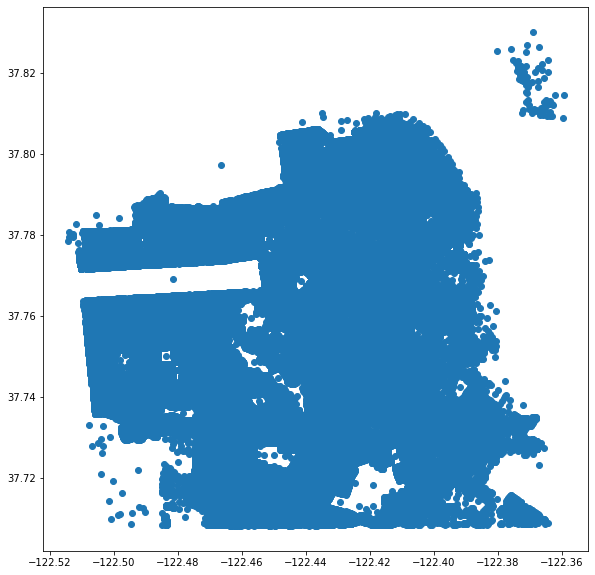

In [34]:
parcels_centroid[parcels_centroid['city'] == 'San Francisco'].plot(figsize=(10,10));

### Perform point on polygon overlay

In [35]:
parcels_centroid.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [36]:
blkgp_2018.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [37]:
parcels_centroid_census = gp.sjoin(parcels_centroid,
                                   blkgp_2018,
                                   how='left',
                                  op='intersects')

In [38]:
parcels_centroid_census.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2142677 entries, 0 to 2142676
Data columns (total 17 columns):
 #   Column            Dtype   
---  ------            -----   
 0   geometry          geometry
 1   parcel_type       object  
 2   city              object  
 3   acres             object  
 4   geom_id           object  
 5   apn_raw           object  
 6   centroid_y        object  
 7   county            object  
 8   centroid_x        object  
 9   parcel_id         object  
 10  apn               object  
 11  joinid_geoserver  object  
 12  shape             object  
 13  index_right       float64 
 14  blkgp_geoi        object  
 15  BLKGRP            object  
 16  tract_geoi        object  
dtypes: float64(1), geometry(1), object(15)
memory usage: 294.3+ MB


In [39]:
parcels_centroid_census.head(5)

,geometry,parcel_type,city,acres,geom_id,apn_raw,centroid_y,county,centroid_x,parcel_id,apn,joinid_geoserver,shape,index_right,blkgp_geoi,BLKGRP,tract_geoi
0,POINT (-121.93159 37.51759),PT00,Fremont,0.130282673690588,N519787380022023374,513-733-63,37.517590870352,1.0,-121.931593621497,AL513073306300,513073306300,AL050297,MULTIPOLYGON (((-121.9314340609999 37.51750546...,3933.0,060014431052,2,06001443105
1,POINT (-121.87500 37.70695),PT00,Dublin,0.134538967957149,7777965113668899400,986-21-92,37.7069546035818,1.0,-121.874998288998,AL986002109200,986002109200,AL064565,MULTIPOLYGON (((-121.874822287 37.707028194000...,3991.0,060014501011,1,06001450101
2,POINT (-122.18977 37.79020),PT00,Oakland,0.0596464335915547,8592358637913523614,30-1939-18,37.7901961828431,1.0,-122.189772409697,AL030193901800,030193901800,AL027583,MULTIPOLYGON (((-122.189637685 37.790153423000...,185.0,060014069002,2,06001406900
3,POINT (-122.29184 37.88007),PT00,Berkeley,0.0652835256088313,N3603110186859102487,60-2400-17,37.8800674363449,1.0,-122.291838389711,AL060240001700,060240001700,AL132639,MULTIPOLYGON (((-122.291720683 37.880021532000...,4088.0,060014219004,4,06001421900
4,POINT (-121.87006 37.73105),PT00,Dublin,0.157939883697465,N7048726851848113656,985-56-4,37.731050067,1.0,-121.870061053204,AL985005600400,985005600400,AL065372,MULTIPOLYGON (((-121.869508097 37.731754854000...,1886.0,060014507521,1,06001450752


### Inspect tracts will null geoids to see why they were not assigned a value
- Appears that these tracts are mostly water tracts

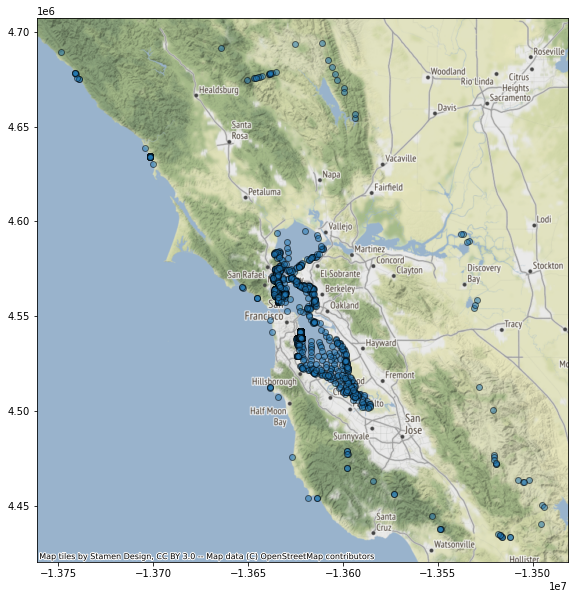

In [40]:
parcels_null_tract = parcels_centroid_census[parcels_centroid_census['tract_geoi'].isnull()].to_crs('epsg:3857')
ax = parcels_null_tract.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax);

### Subset pracels_centroid_census geodataframe for upsert to Socrata

In [41]:
parcels_centroid_census.columns

Index(['geometry', 'parcel_type', 'city', 'acres', 'geom_id', 'apn_raw',
       'centroid_y', 'county', 'centroid_x', 'parcel_id', 'apn',
       'joinid_geoserver', 'shape', 'index_right', 'blkgp_geoi', 'BLKGRP',
       'tract_geoi'],
      dtype='object')

In [42]:
sub_columns = ['parcel_id','blkgp_geoi','tract_geoi']
upsert_df_socrata(parcels_centroid_census[sub_columns],housing_site_db_id,chunksize=100000)

upserting data to Socrata in 22 chunks of 100000 rows each
upserted chunk 0
upserted chunk 1
upserted chunk 2
upserted chunk 3
upserted chunk 4
upserted chunk 5
upserted chunk 6
upserted chunk 7
upserted chunk 8
upserted chunk 9
upserted chunk 10
upserted chunk 11
upserted chunk 12
upserted chunk 13
upserted chunk 14
upserted chunk 15
upserted chunk 16
upserted chunk 17
upserted chunk 18
upserted chunk 19
upserted chunk 20
upserted chunk 21
data upserted to d8wd-vg4y
took 9.4435 minutes
